## Imports

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

## EDA and pre-processing

In [2]:
train = pd.read_csv('data/train.csv')
building_metadata = pd.read_csv('data/building_metadata.csv')
weather = pd.read_csv('data/weather_train.csv')

In [3]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [4]:
building_metadata.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [5]:
weather.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


#### **Step 1**: Merge between train and building_metadata

building_metadata contain building_id so we will merge on that first.

In [6]:
df = train.merge(building_metadata, on='building_id', how='left')


In [7]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008.0,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004.0,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991.0,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002.0,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975.0,NaN


#### **Step 2**: Merge df with weather_train

The weather_train.csv dataset contains site_id and timestamp, so we need to merge using these keys.

We need to ensure timestamp is in datetime format before merging to avoid mismatches.

In [8]:
df['timestamp'] = pd.to_datetime(df['timestamp']) 
weather['timestamp'] = pd.to_datetime(weather['timestamp'])

df = df.merge(weather, on=['site_id', 'timestamp'], how='left')
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01,0.0,0,Education,7432,2008.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,1,0,2016-01-01,0.0,0,Education,2720,2004.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
2,2,0,2016-01-01,0.0,0,Education,5376,1991.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
3,3,0,2016-01-01,0.0,0,Education,23685,2002.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
4,4,0,2016-01-01,0.0,0,Education,116607,1975.0,NaN,25.0,6.0,20.0,NaN,1019.7,0.0,0.0


#### **Step 3**: Understanding the dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
 #   Column              Dtype         
---  ------              -----         
 0   building_id         int64         
 1   meter               int64         
 2   timestamp           datetime64[ns]
 3   meter_reading       float64       
 4   site_id             int64         
 5   primary_use         object        
 6   square_feet         int64         
 7   year_built          float64       
 8   floor_count         float64       
 9   air_temperature     float64       
 10  cloud_coverage      float64       
 11  dew_temperature     float64       
 12  precip_depth_1_hr   float64       
 13  sea_level_pressure  float64       
 14  wind_direction      float64       
 15  wind_speed          float64       
dtypes: datetime64[ns](1), float64(10), int64(4), object(1)
memory usage: 2.4+ GB


In [10]:
print(df.shape)

(20216100, 16)


In [11]:
df.describe()

,building_id,meter,timestamp,meter_reading,site_id,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
count,2.021610e+07,2.021610e+07,20216100,2.021610e+07,2.021610e+07,2.021610e+07,8.088455e+06,3.506933e+06,2.011944e+07,1.139074e+07,2.011596e+07,1.646708e+07,1.898443e+07,1.876705e+07,2.007242e+07
mean,7.992780e+02,6.624412e-01,2016-07-03 22:59:40.301601792,2.117121e+03,7.992232e+00,1.077830e+05,1.968277e+03,4.184848e+00,1.598795e+01,1.900423e+00,7.747429e+00,7.964155e-01,1.016085e+03,1.730151e+02,3.377525e+00
min,0.000000e+00,0.000000e+00,2016-01-01 00:00:00,0.000000e+00,0.000000e+00,2.830000e+02,1.900000e+03,1.000000e+00,-2.890000e+01,0.000000e+00,-3.500000e+01,-1.000000e+00,9.682000e+02,0.000000e+00,0.000000e+00
25%,3.930000e+02,0.000000e+00,2016-04-05 21:00:00,1.830000e+01,3.000000e+00,3.252700e+04,1.951000e+03,1.000000e+00,8.600000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.011600e+03,7.000000e+01,2.100000e+00
50%,8.950000e+02,0.000000e+00,2016-07-04 17:00:00,7.877500e+01,9.000000e+00,7.270900e+04,1.969000e+03,3.000000e+00,1.670000e+01,0.000000e+00,8.900000e+00,0.000000e+00,1.016000e+03,1.800000e+02,3.100000e+00
75%,1.179000e+03,1.000000e+00,2016-10-02 22:00:00,2.679840e+02,1.300000e+01,1.391130e+05,1.993000e+03,6.000000e+00,2.410000e+01,4.000000e+00,1.610000e+01,0.000000e+00,1.020500e+03,2.800000e+02,4.600000e+00
max,1.448000e+03,3.000000e+00,2016-12-31 23:00:00,2.190470e+07,1.500000e+01,8.750000e+05,2.017000e+03,2.600000e+01,4.720000e+01,9.000000e+00,2.610000e+01,3.430000e+02,1.045500e+03,3.600000e+02,1.900000e+01
std,4.269133e+02,9.309921e-01,NaN,1.532356e+05,5.099060e+00,1.171424e+05,3.020815e+01,4.008277e+00,1.094729e+01,2.402909e+00,1.017867e+01,7.468997e+00,7.060539e+00,1.140574e+02,2.265694e+00


#### **Step 4**: Null values

Next, we check if there are any null values in our dataset.

In [12]:
df.isnull().sum().sort_values(ascending=False)

floor_count           16709167
year_built            12127645
cloud_coverage         8825365
precip_depth_1_hr      3749023
wind_direction         1449048
sea_level_pressure     1231669
wind_speed              143676
dew_temperature         100140
air_temperature          96658
building_id                  0
meter                        0
timestamp                    0
meter_reading                0
site_id                      0
primary_use                  0
square_feet                  0
dtype: int64

We can see that a lot of our columns have missing values. We need to handle them properly because it could impact our model's performance later on.
The good news is that there are no missing values in our target variable: meter_reading.

In [13]:
display((df.isnull().sum()/df.shape[0]).sort_values(ascending=False))

floor_count           0.826528
year_built            0.599900
cloud_coverage        0.436551
precip_depth_1_hr     0.185447
wind_direction        0.071678
sea_level_pressure    0.060925
wind_speed            0.007107
dew_temperature       0.004953
air_temperature       0.004781
building_id           0.000000
meter                 0.000000
timestamp             0.000000
meter_reading         0.000000
site_id               0.000000
primary_use           0.000000
square_feet           0.000000
dtype: float64

In [14]:
# we drop all the columns with more than 40% missing values

df = df.drop(['cloud_coverage', 'year_built', 'floor_count'], axis=1)

In [ ]:
# fill missing values with knn imputer or mean for efficiency
from sklearn.impute import KNNImputer


# method = 'knn'
method = 'mean'

if method == 'knn':
    df_numeric = df.select_dtypes(exclude=['object', 'datetime64[ns]'])

    knn_imputer = KNNImputer(n_neighbors=5)
    df_imputed = knn_imputer.fit_transform(df_numeric)

    df_imputed = pd.DataFrame(df_imputed, columns=df_numeric.columns)

    # Add back the datetime column
    df_imputed['date'] = df['date'].values
elif method == 'mean':
    df_imputed = df.fillna(df.mean())


df_imputed.head()

#### **Step 5**: Check the duplicates

We also want to make sure there are no duplicates in the dataset.

In [15]:
df.shape

(20216100, 13)

In [16]:
df=df.drop_duplicates()

In [17]:
df.shape

(20216100, 13)

The number of rows hasn't changed so that means there were no duplicates.

#### **Step 6**: Feature engineering on timestamp column

We want to separate the date from the time. This way it will be easier to manipulate the dataset when we want to analyse things hourly or daily or monthly.

For the hour, we only take the first part because the data is always taken at full hours like 9:00 or 21:00.

We also are decomposing the date into day, month and year which will make things easier when we need to filter data based on timestamps.

For the day, we also use dt.dayoftheweek to get a value depending on the date: 1 for Monday, 2 for Tuesday, etc. The specific day number (like the 10th or the 23rd) is not necessarily important. Something that would be more relevant is knowing if it is a Monday, Tuesday, etc., and then whether it's a weekday or weekend.
Once we have this, we can determine if the day is a week day or weekend: if the number is between 1 and 5 it's the week and if the number is 6 or 7, it's the weekend.

In [18]:
df['date']=df['timestamp'].dt.date.astype('datetime64[ns]')
df['hour'] = df['timestamp'].dt.hour
df['year']=df['timestamp'].dt.year
df['month']=df['timestamp'].dt.month
df['day']=df['timestamp'].dt.day
df['dayofweek'] = df['timestamp'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
df=df.drop('timestamp', axis=1)
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,date,hour,year,month,day,dayofweek,is_weekend
0,0,0,0.0,0,Education,7432,25.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,2016,1,1,4,0
1,1,0,0.0,0,Education,2720,25.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,2016,1,1,4,0
2,2,0,0.0,0,Education,5376,25.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,2016,1,1,4,0
3,3,0,0.0,0,Education,23685,25.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,2016,1,1,4,0
4,4,0,0.0,0,Education,116607,25.0,20.0,NaN,1019.7,0.0,0.0,2016-01-01,0,2016,1,1,4,0


#### **Step 7**: Ensuring there are no negative values in the target variable
Now we also want to make sure there are no negative meter readings as that would be impossible.

In [19]:
print(df['meter_reading'].describe())

count    2.021610e+07
mean     2.117121e+03
std      1.532356e+05
min      0.000000e+00
25%      1.830000e+01
50%      7.877500e+01
75%      2.679840e+02
max      2.190470e+07
Name: meter_reading, dtype: float64


In [20]:
print(df['meter_reading'].min())

0.0


We can see that the minimum value is 0.0 so there are no mistakes.

#### **Step 8**: Time Cyclic Encoding

We will use Time Cyclic Encoding using sine and cosine transformations to handle the cyclical nature of the time-based features such as hour, dayofweek and month.

Many machine learning models (like linear regression and tree-based models) assume that values have a linear relationship meaning that larger values are more important. But time-based variables don't behave that way. For example, the hour feature goes from 0 to 23, but 23:00 is just one hour away from 0:00 (midnight), which is not far apart. Similarly, dayofweek runs from 0 (Monday) to 6 (Sunday), but Sunday (6) is right next to Monday (0).

If we just feed these numbers into a model, it might think that 23 is much bigger than 0, when in reality, they are close in time. To fix this, we use sine and cosine transformations to map these values onto a circular space. By doing this, values that are close in time remain close mathematically (e.g., hour 23 and hour 0 will have similar encoded values) and the model will capture cyclical patterns more effectively.

In [21]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['dayofweek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayofweek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

In [22]:
df.head()

,building_id,meter,meter_reading,site_id,primary_use,square_feet,air_temperature,dew_temperature,precip_depth_1_hr,sea_level_pressure,...,month,day,dayofweek,is_weekend,hour_sin,hour_cos,dayofweek_sin,dayofweek_cos,month_sin,month_cos
0,0,0,0.0,0,Education,7432,25.0,20.0,NaN,1019.7,...,1,1,4,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
1,1,0,0.0,0,Education,2720,25.0,20.0,NaN,1019.7,...,1,1,4,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
2,2,0,0.0,0,Education,5376,25.0,20.0,NaN,1019.7,...,1,1,4,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
3,3,0,0.0,0,Education,23685,25.0,20.0,NaN,1019.7,...,1,1,4,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025
4,4,0,0.0,0,Education,116607,25.0,20.0,NaN,1019.7,...,1,1,4,0,0.0,1.0,-0.433884,-0.900969,0.5,0.866025


# other preprocessing ???

## Visualizations

### Distribution of Energy Consumption

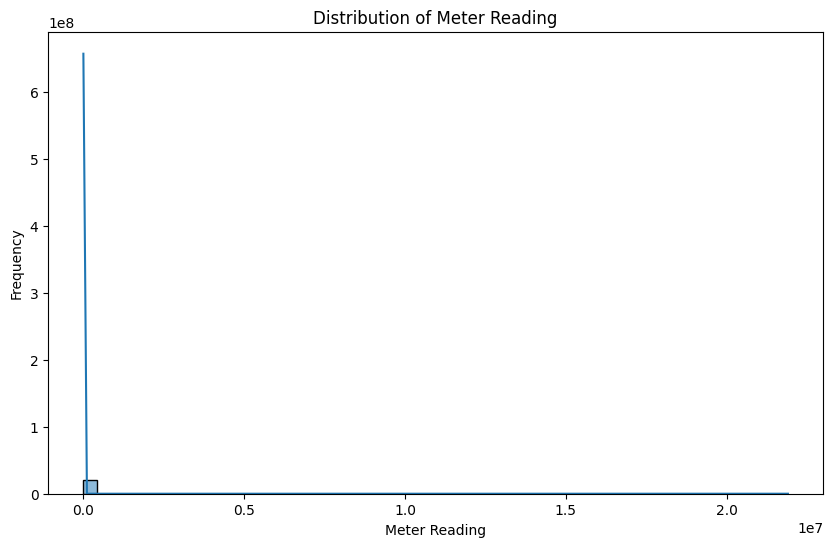

In [23]:
plt.figure(figsize=(10, 6))
sns.histplot(df['meter_reading'], bins=50, kde=True)
plt.title('Distribution of Meter Reading')
plt.xlabel('Meter Reading')
plt.ylabel('Frequency')
plt.show()


### Average Energy Consumption by Hour of the Day

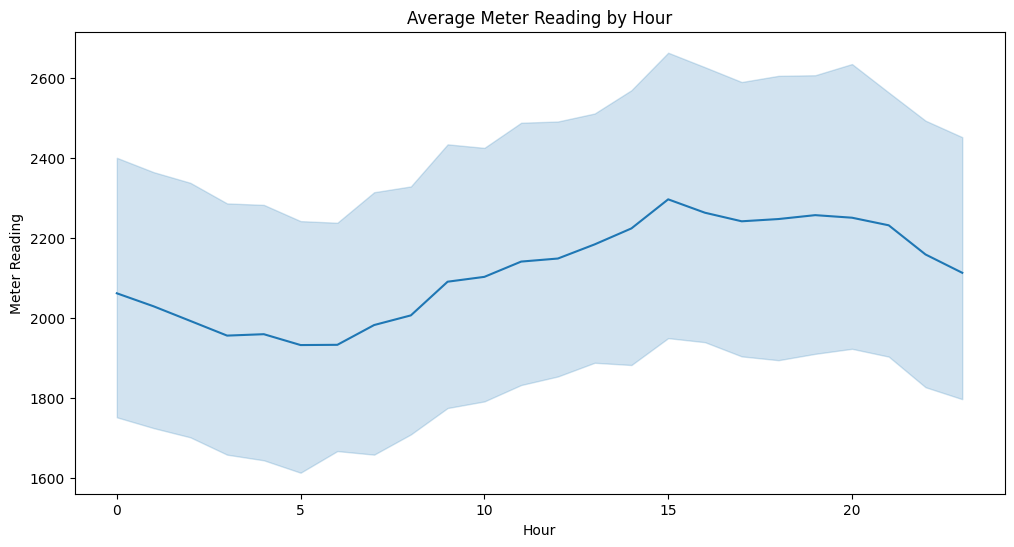

In [24]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='meter_reading', data=df)
plt.title('Average Meter Reading by Hour')
plt.xlabel('Hour')
plt.ylabel('Meter Reading')
plt.show()

### Energy Consumption on Weekends vs. Weekdays

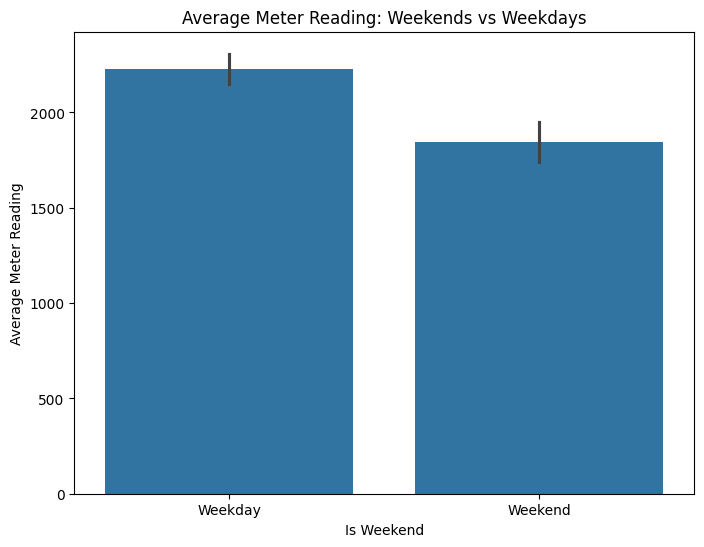

In [25]:
plt.figure(figsize=(8, 6))
sns.barplot(x='is_weekend', y='meter_reading', data=df)
plt.title('Average Meter Reading: Weekends vs Weekdays')
plt.xlabel('Is Weekend')
plt.ylabel('Average Meter Reading')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()


## **-> -> -> 10 viz**

### Distribution of Energy Consumption

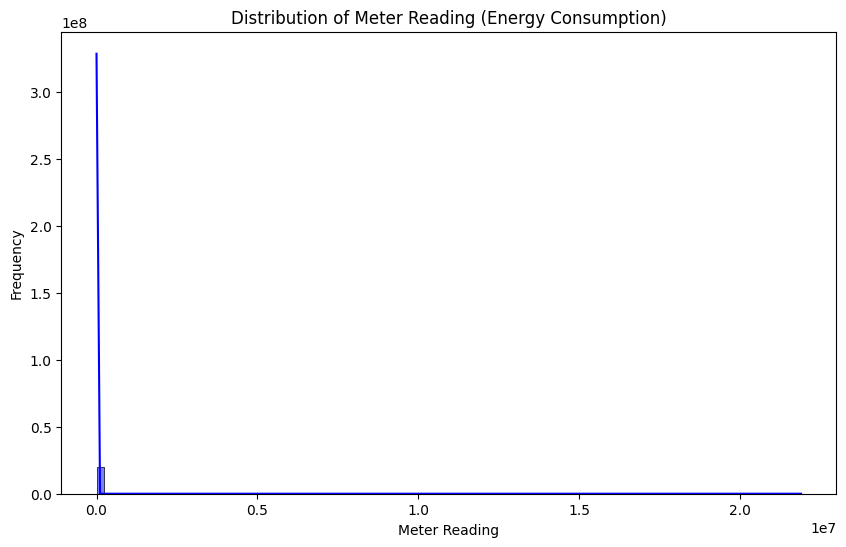

In [26]:
plt.figure(figsize=(10, 6))
sns.histplot(df['meter_reading'], bins=100, kde=True, color='blue')
plt.title('Distribution of Meter Reading (Energy Consumption)')
plt.xlabel('Meter Reading')
plt.ylabel('Frequency')
plt.show()

### Energy Consumption by Meter Type (Most Used Energy Source)

C:\Users\lorra\AppData\Local\Temp\ipykernel_32392\1207286170.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}),


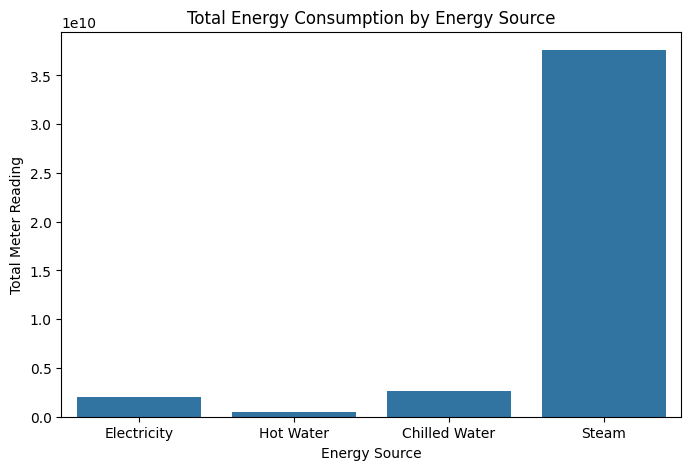

In [27]:
plt.figure(figsize=(8, 5))
sns.barplot(x=df['meter'].map({0: 'Electricity', 1: 'Chilled Water', 2: 'Steam', 3: 'Hot Water'}), 
            y=df['meter_reading'], estimator=sum, ci=None)
plt.title('Total Energy Consumption by Energy Source')
plt.xlabel('Energy Source')
plt.ylabel('Total Meter Reading')
plt.show()


### Hourly Energy Usage Pattern

C:\Users\lorra\AppData\Local\Temp\ipykernel_32392\2513089811.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)


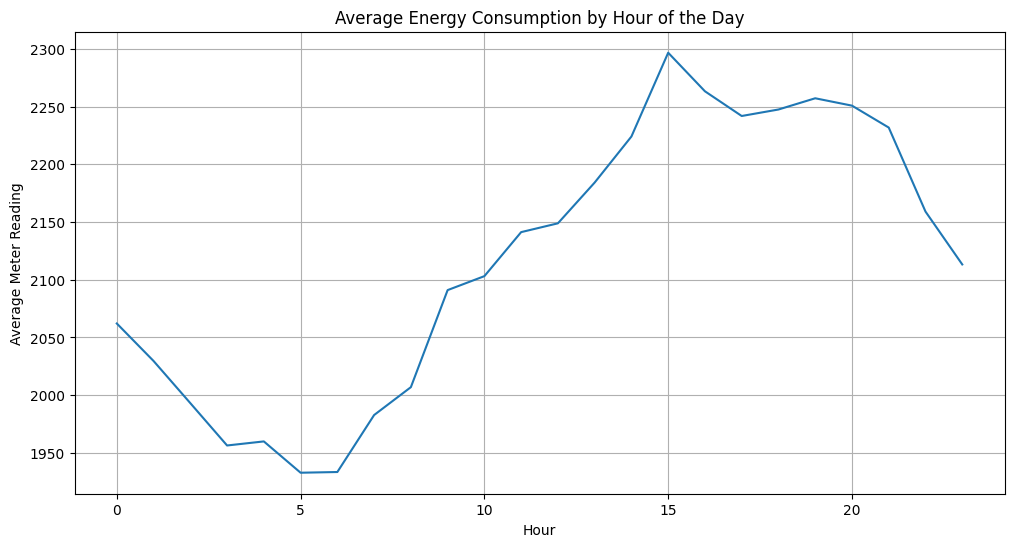

In [28]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='hour', y='meter_reading', data=df, estimator='mean', ci=None)
plt.title('Average Energy Consumption by Hour of the Day')
plt.xlabel('Hour')
plt.ylabel('Average Meter Reading')
plt.grid()
plt.show()


### Monthly Energy Usage Evolution

C:\Users\lorra\AppData\Local\Temp\ipykernel_32392\458792480.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='month', y='meter_reading', data=df, estimator='mean', ci=None)


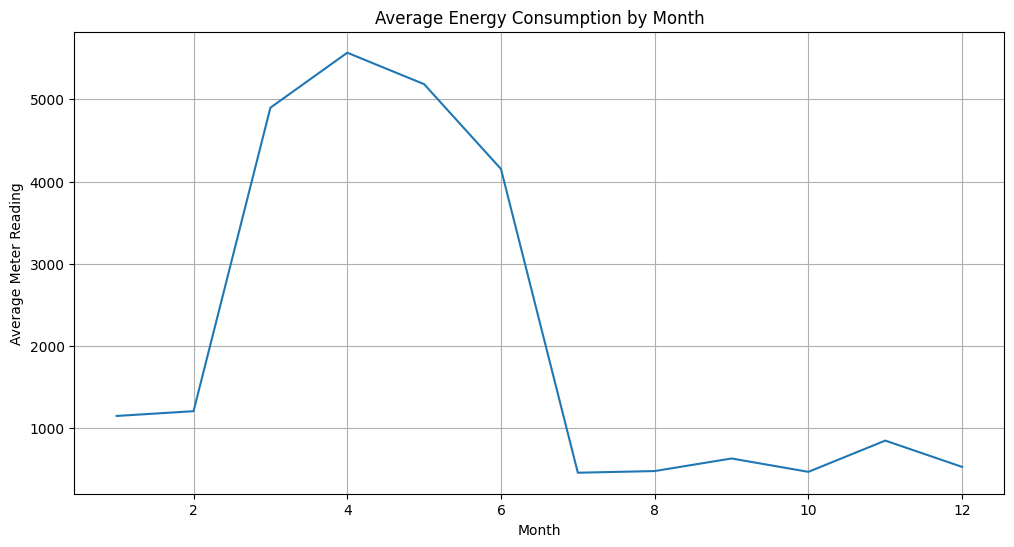

In [29]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='month', y='meter_reading', data=df, estimator='mean', ci=None)
plt.title('Average Energy Consumption by Month')
plt.xlabel('Month')
plt.ylabel('Average Meter Reading')
plt.grid()
plt.show()


### Daily Energy Consumption Evolution (By Month)

C:\Users\lorra\AppData\Local\Temp\ipykernel_32392\2209395781.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.lineplot(x='day', y='meter_reading', hue='month', data=df, estimator='mean', palette='coolwarm', ci=None)


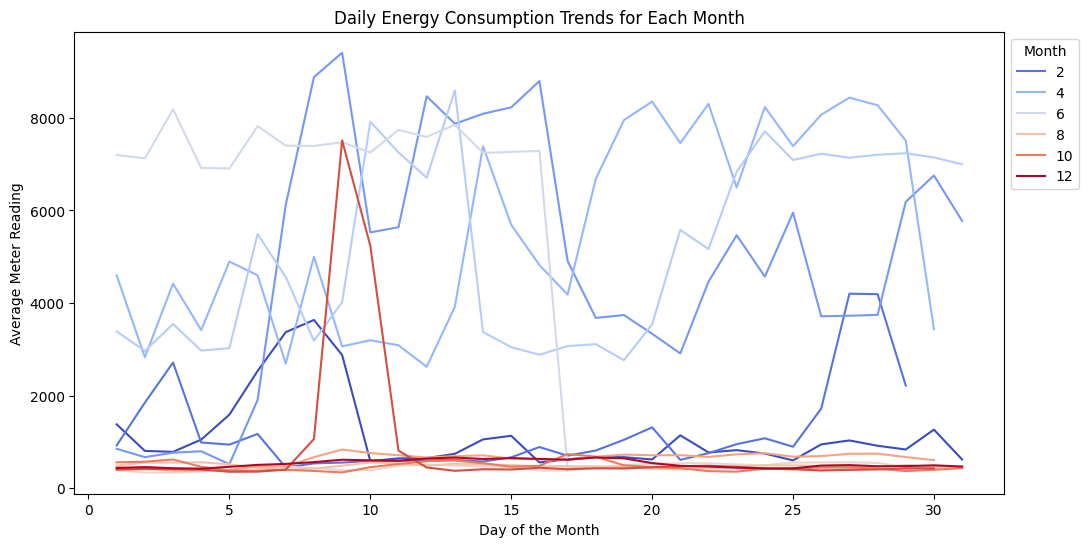

In [30]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='day', y='meter_reading', hue='month', data=df, estimator='mean', palette='coolwarm', ci=None)
plt.title('Daily Energy Consumption Trends for Each Month')
plt.xlabel('Day of the Month')
plt.ylabel('Average Meter Reading')
plt.legend(title='Month', bbox_to_anchor=(1, 1))
plt.show()


### Energy Usage on Weekends vs. Weekdays

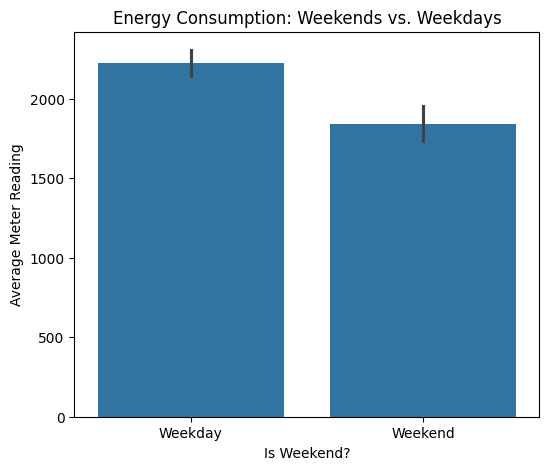

In [31]:
plt.figure(figsize=(6, 5))
sns.barplot(x='is_weekend', y='meter_reading', data=df, estimator='mean')
plt.title('Energy Consumption: Weekends vs. Weekdays')
plt.xlabel('Is Weekend?')
plt.ylabel('Average Meter Reading')
plt.xticks([0, 1], ['Weekday', 'Weekend'])
plt.show()


### Correlation Between Energy and Building Metadata

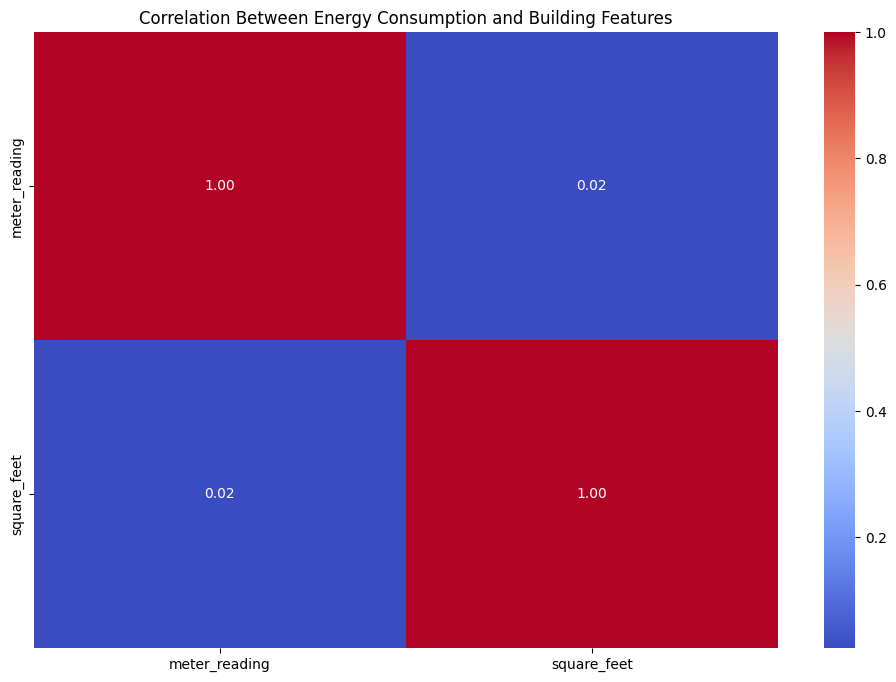

In [32]:
plt.figure(figsize=(12, 8))
sns.heatmap(df[['meter_reading', 'square_feet']].corr(), 
            annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between Energy Consumption and Building Features')
plt.show()


### Relationship Between Energy Usage and Temperature

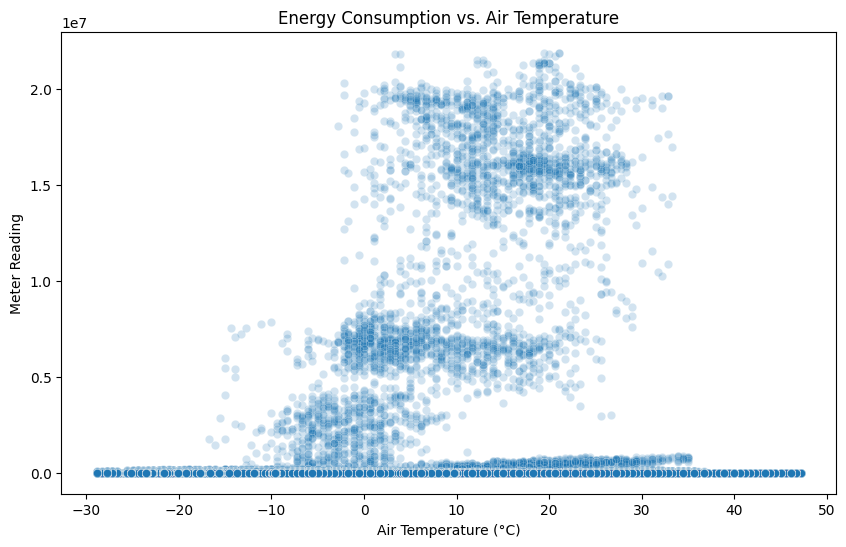

In [33]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='air_temperature', y='meter_reading', data=df, alpha=0.2)
plt.title('Energy Consumption vs. Air Temperature')
plt.xlabel('Air Temperature (°C)')
plt.ylabel('Meter Reading')
plt.show()


### Time Series Analysis of Energy Consumption

In [34]:
import plotly.express as px

fig = px.line(df.sample(5000), x='date', y='meter_reading', title='Energy Consumption Over Time')
fig.show()


### Energy Consumption by Building Type

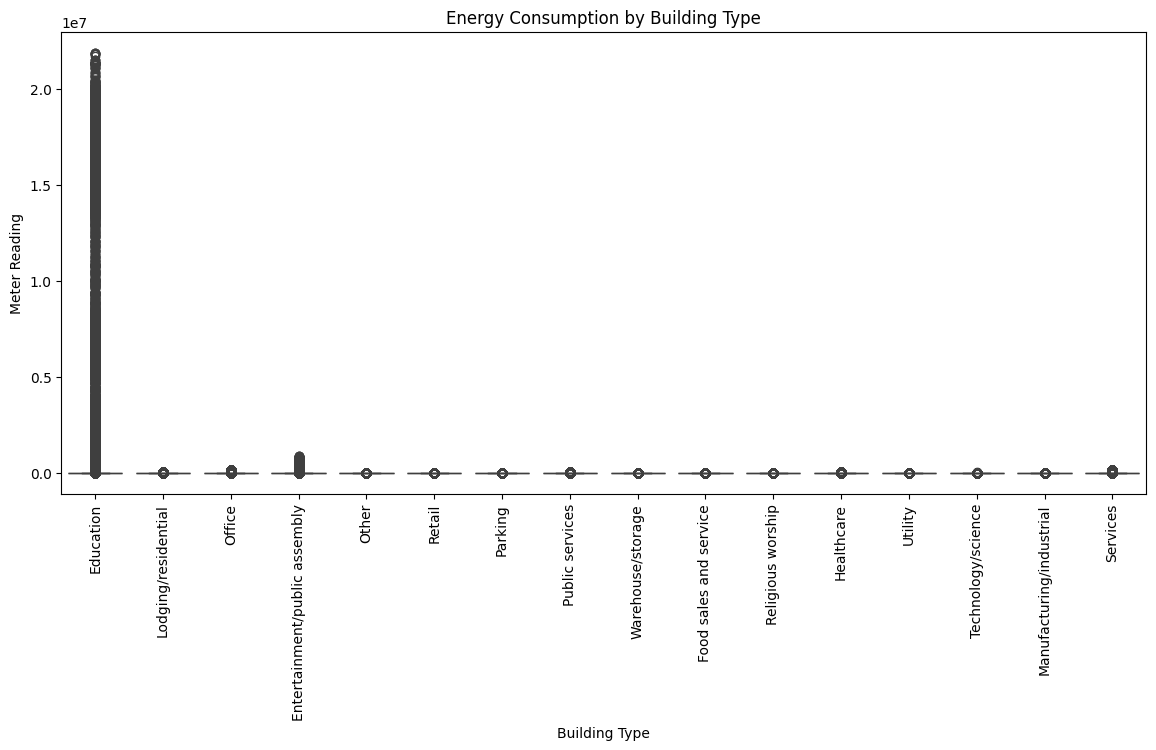

In [35]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='primary_use', y='meter_reading', data=df)
plt.xticks(rotation=90)
plt.title('Energy Consumption by Building Type')
plt.xlabel('Building Type')
plt.ylabel('Meter Reading')
plt.show()


In [ ]:
# very simple model to predict the meter_reading
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X = df[['square_feet', 'air_temperature', 'dew_temperature', 'hour', 'dayofweek', 'month', 'is_weekend']]
y = df['meter_reading']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
